Function Definitions

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def generate_data(n, d, sigma, anomaly_type = "none"):
    X = np.random.uniform(-1, 1, size=(n, d))
    theta = 1 + np.array([((-1) ** (j+1)) / (j + 1) for j in range(d)])
    y = X @ theta + np.random.normal(0, sigma, n)

    # artificial anomalies
    if anomaly_type == "covariate":
      X += np.random.normal(0, 0.5, size=(n,d)) # white noise
    elif anomaly_type == "outcome":
      y[range(int(n*0.05))] += 10 # outliers

    return X, y, theta

# optimistic and pesimistic regression

def OrdinaryLeastSquares(X, y):
    theta = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y
    return theta

def OutcomeOptimistic(X, y, alpha, gamma, L):
    # main part
    n, d = X.shape
    theta = cp.Variable(d)
    mu = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(y - X@theta - mu)/n + (1/(25*L))*(cp.norm(mu, alpha)/(n**(1/alpha)))**(gamma))
    problem = cp.Problem(objective)
    problem.solve()
    return theta.value

def CovariatePessimistic(X, y, alpha, L):
    # gamma = infinity (to follow Ribeiro et al. (2023))
    # dual norm exponent
    if alpha == 1:
      q = np.Inf
    else:
      q = alpha / (alpha - 1)
    # main part
    n, d = X.shape
    theta = cp.Variable(d)
    objective = (1 / n) * cp.sum((cp.abs(X @ theta - y) + L * cp.pnorm(theta, p=q)) ** 2)
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve()
    return theta.value

# density power divergence regression

from scipy.optimize import minimize

def DPDregression(X, y, exponent, sigma):
    # sigma**2 = V[y|X] is known
    n, d = X.shape

    def p(theta):
        residuals = y - X @ theta
        return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(residuals**2 / (2*sigma**2)))

    def objective(theta):
        if exponent == 0:
          return(-np.mean(np.log(p(theta))))
        else:
          return(-(1/exponent) * np.mean((p(theta))**exponent))

    initial_theta = OrdinaryLeastSquares(X, y)
    result = minimize(fun=objective, x0=initial_theta, method='Nelder-Mead')

    return result.x



---


**Experiment 1**: Bias-variance trade-off in outcome optimistic and covariate pessimitic regression

(Figures 1-4, 6)

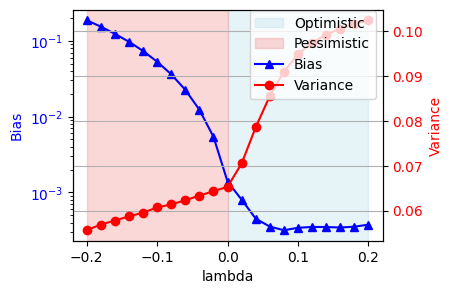

In [ ]:
## Experiments

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# experimental settings
N = 100  # number of trials
n = 50  # sample size
d = 3   # covariate dimension
alpha = gamma = 1
sigma = 1 # standard deviation (for residuals)
anomaly_type = "none" # "covariate", "outcome", or "none"
L_values = np.arange(-0.2, 0.22, 0.02)  # range of L (lambda in our manuscript)

# fix random seed
np.random.seed(42)

# list to save results
results = []

for i in range(N):
    X, y, true_theta = generate_data(n, d, sigma, anomaly_type)
    for L in L_values:
        if L == 0:
            estimated_theta = OrdinaryLeastSquares(X, y)
            results.append([i, L, 'OLS', estimated_theta])
        elif L > 0:
            estimated_theta = OutcomeOptimistic(X, y, alpha, gamma, L)
            results.append([i, L, 'OO', estimated_theta])
        else:
            estimated_theta = CovariatePessimistic(X, y, alpha, -L)
            results.append([i, L, 'CP', estimated_theta])


## Visualization

# transformation into dataframe
df_results = pd.DataFrame(results, columns=['experiment_id', 'L', 'method', 'theta'])

# computation of bias and variance terms
bias_results = []
variance_results = []
vx = 1/3

for L in L_values:
    if L == 0:
        method = 'OLS'
    elif L > 0:
        method = 'OO'
    else:
        method = 'CP'

    thetas = np.stack(df_results[(df_results['L'] == L) & (df_results['method'] == method)]['theta'].values)
    mean_theta = np.mean(thetas, axis=0)
    bias = np.sqrt(vx) * np.linalg.norm(mean_theta - true_theta)**2
    variance = vx * np.mean(np.linalg.norm(thetas - mean_theta, axis=1)**2)
    bias_results.append([L, bias])
    variance_results.append([L, variance])

# save bias and variance terms into dataframe
df_bias = pd.DataFrame(bias_results, columns=['L', 'bias'])
df_variance = pd.DataFrame(variance_results, columns=['L', 'variance'])

# plot size
fig, ax1 = plt.subplots(figsize=(4, 3))

# optimistic region
ax1.axvspan(0, 0.2, color='lightblue', alpha=0.3, label='Optimistic')

# pessimistic region
ax1.axvspan(-0.2, 0, color='lightcoral', alpha=0.3, label='Pessimistic')

# bias plot (log scale)
ax1.plot(df_bias['L'], df_bias['bias'], label='Bias', color='blue', marker='^')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Bias', color='blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue')

# variance plot (standard scale)
ax2 = ax1.twinx()
ax2.plot(df_variance['L'], df_variance['variance'], label='Variance', color='red', marker='o')
ax2.set_ylabel('Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

---
**Experiment 2**: model misspecified

(Figure 5)

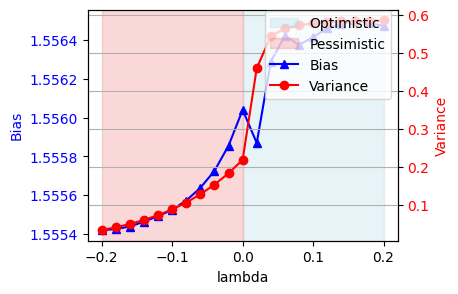

In [ ]:
def transform(z):
  # return(np.exp(z))
  # return(np.cos(z))
  return(z**2+1)

def generate_data_exp(n, d, sigma):
    X = np.random.uniform(-1, 1, size=(n, d))
    theta = np.array([((-1) ** (j+1)) / (j + 1) for j in range(d)])
    y = transform(X @ theta) + np.random.normal(0, sigma, n)
    return X, y, theta

## Experiments

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# experimental settings
N = 100  # number of trials
n = 50  # sample size
d = 3   # covariate dimension
alpha = gamma = 1
sigma = 1  # standard deviation (for residuals)
L_values = np.arange(-0.2, 0.22, 0.02)  # range of L (lambda in our manuscript)

# fix random seed
np.random.seed(42)

# list to save results
results = []

for i in range(N):
    X, y, true_theta = generate_data_exp(n, d, sigma)
    for L in L_values:
        if L == 0:
            estimated_theta = OrdinaryLeastSquares(X, y)
            results.append([i, L, 'OLS', estimated_theta])
        elif L > 0:
            estimated_theta = OutcomeOptimistic(X, y, alpha, gamma, L)
            results.append([i, L, 'OO', estimated_theta])
        else:
            estimated_theta = CovariatePessimistic(X, y, alpha, -L)
            results.append([i, L, 'CP', estimated_theta])

## Visualization

# transformation into dataframe
df_results = pd.DataFrame(results, columns=['experiment_id', 'L', 'method', 'theta'])

# computation of bias and variance terms
bias_results = []
variance_results = []
vx = 1/3

for L in L_values:
    if L == 0:
        method = 'OLS'
    elif L > 0:
        method = 'OO'
    else:
        method = 'CP'

    thetas = np.stack(df_results[(df_results['L'] == L) & (df_results['method'] == method)]['theta'].values)
    mean_theta = np.mean(thetas, axis=0)

    linspace = np.linspace(-1, 1, 10**2)
    grid1, grid2, grid3 = np.meshgrid(linspace, linspace, linspace)
    X = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
    bias = np.sqrt(np.mean((transform(X @ true_theta) - (X @ mean_theta))**2)) # empirical bias
    variance = vx * np.mean(np.linalg.norm(thetas - mean_theta, axis=1)**2)
    bias_results.append([L, bias])
    variance_results.append([L, variance])

# save bias and variance terms into dataframe
df_bias = pd.DataFrame(bias_results, columns=['L', 'bias'])
df_variance = pd.DataFrame(variance_results, columns=['L', 'variance'])

# plot size
fig, ax1 = plt.subplots(figsize=(4, 3))

# optimistic region
ax1.axvspan(0, 0.2, color='lightblue', alpha=0.3, label='Optimistic')

# pessimistic region
ax1.axvspan(-0.2, 0, color='lightcoral', alpha=0.3, label='Pessimistic')

# bias plot (log scale)
ax1.plot(df_bias['L'], df_bias['bias'], label='Bias', color='blue', marker='^')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Bias', color='blue')
# ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue')

# variance plot (standard scale)
ax2 = ax1.twinx()
ax2.plot(df_variance['L'], df_variance['variance'], label='Variance', color='red', marker='o')
ax2.set_ylabel('Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

---
**Experiment 3**: Density-power-divergence regression

(Figure 7)

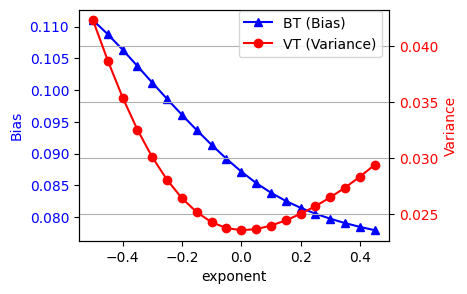

In [ ]:
## Experiments

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# experimental settings
N = 100  # number of trials
n = 100  # sample size
d = 3   # covariate dimension
sigma = 1  # standard deviation (for residuals)
anomaly_type = "covariate" # "covariate", "outcome", or "none"
exponent_values = np.arange(-0.5, 0.5, 0.05)  # range of beta

# fix random seed
np.random.seed(42)

results = []

for i in range(N):
    X, y, true_theta = generate_data(n, d, sigma, anomaly_type)
    for exponent in exponent_values:
        estimated_theta = DPDregression(X, y, exponent, sigma)
        results.append([i, exponent, estimated_theta])


## Visualization

df_results = pd.DataFrame(results, columns=['experiment_id', 'exponent', 'theta'])

bias_results = []
variance_results = []
vx = 1/3

for exponent in exponent_values:
    thetas = np.stack(df_results[df_results['exponent'] == exponent]['theta'].values)
    mean_theta = np.mean(thetas, axis=0)
    bias = np.sqrt(vx) * np.linalg.norm(mean_theta - true_theta)**2
    variance = vx * np.mean(np.linalg.norm(thetas - mean_theta, axis=1)**2)
    bias_results.append([exponent, bias])
    variance_results.append([exponent, variance])

df_bias = pd.DataFrame(bias_results, columns=['exponent', 'bias'])
df_variance = pd.DataFrame(variance_results, columns=['exponent', 'variance'])

fig, ax1 = plt.subplots(figsize=(4, 3))

# bias plot (log scale)
ax1.plot(df_bias['exponent'], df_bias['bias']**2, label='BT (Bias)', color='blue', marker='^')
ax1.set_xlabel('exponent')
ax1.set_ylabel('Bias', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# variance plot (standard scale)
ax2 = ax1.twinx()
ax2.plot(df_variance['exponent'], df_variance['variance'], label='VT (Variance)', color='red', marker='o')
ax2.set_ylabel('Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()